## Sample errors from made up Variogram model -> sample points -> create Variogram

In [21]:
%load_ext autoreload
%autoreload 2

from ocean_navigation_simulator.generative_error_model.models.OceanCurrentNoiseField import OceanCurrentNoiseField, timedelta_to_hours
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of ocean_navigation_simulator.generative_error_model.models.SimplexNoiseModel failed: Traceback (most recent call last):
  File "/home/jonas/miniconda3/envs/ocean_platform/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/jonas/miniconda3/envs/ocean_platform/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/jonas/miniconda3/envs/ocean_platform/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/jonas/miniconda3/envs/ocean_platform/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 317, in update_class
    update_instances(old, new)
  File "/home/jonas/miniconda3/envs/ocean_platform/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 280, in update_instances
    ref.__class__ = new
  File "<string

In [27]:
ranges = [1.0, 600.0, 600.0, 30.0] # -> go into simplex noise
rng = np.random.default_rng(12345678)
noise_field = OceanCurrentNoiseField()
noise_field.reset(rng)

lon_range = (-140, -120)
lat_range = (20, 30)
t_range = (datetime.datetime(2022, 5, 10, 12, 30, 0),
           datetime.datetime(2022, 5, 19, 12, 30, 0))

sample = noise_field.get_noise(lon_range, lat_range, t_range)
display(sample)

[autoreload of ocean_navigation_simulator.generative_error_model.models.SimplexNoiseModel failed: Traceback (most recent call last):
  File "/home/jonas/miniconda3/envs/ocean_platform/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/jonas/miniconda3/envs/ocean_platform/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/jonas/miniconda3/envs/ocean_platform/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/jonas/miniconda3/envs/ocean_platform/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 317, in update_class
    update_instances(old, new)
  File "/home/jonas/miniconda3/envs/ocean_platform/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 280, in update_instances
    ref.__class__ = new
  File "<string

<xarray.Dataset>
Dimensions:  (lon: 240, lat: 120, time: 216)
Coordinates:
  * lon      (lon) float64 -140.0 -139.9 -139.8 -139.7 ... -120.2 -120.2 -120.1
  * lat      (lat) float64 20.0 20.08 20.17 20.25 ... 29.67 29.75 29.83 29.92
  * time     (time) datetime64[ns] 2022-05-10T12:30:00 ... 2022-05-19T11:30:00
Data variables:
    u_error  (lon, lat, time) object -0.6443754314275112 ... -1.398921554431936
    v_error  (lon, lat, time) object 1.0118567478468026 ... -0.9605354201157549
Attributes:
    description:  An ocean current error sample over time and space.

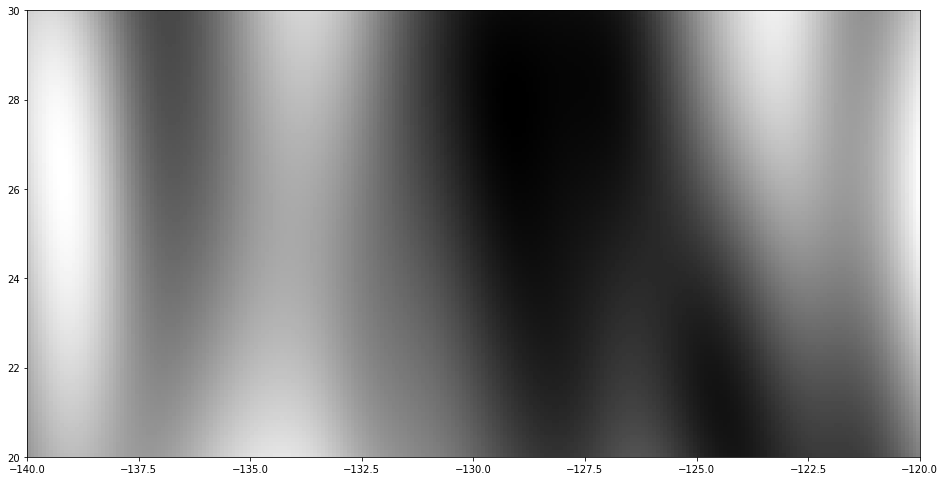

In [28]:
# vis noise at single time step
sample_time_step = sample["u_error"][:, :, 0].values
sample_time_step = sample_time_step.T
fig = plt.figure(figsize=(16,10))
plt.imshow(sample_time_step.astype(float), cmap="gray", origin="lower", extent=[-140,-120,20,30])

Sample ~30 points per time step. But these cannot be random but have to be a trajectory

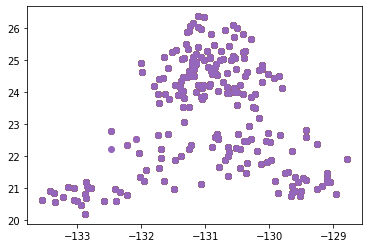

In [24]:
# sample lat, lon coordinates from numpy uniform and perturb for subsequent
# time steps to simulate a trajectory

n = 30  # points per time step
lon_positions = np.random.uniform(low=lon_range[0], high=lon_range[1], size=n)
lat_positions = np.random.uniform(low=lat_range[0], high=lat_range[1], size=n)
time = t_range[0]
buoy_index = list(range(n))

df = pd.DataFrame({"time": time,
                   "lon": lon_positions,
                   "lat": lat_positions,
                   "buoy": buoy_index})

# perturb initial positions slightly
time_steps = timedelta_to_hours(t_range[1] - t_range[0])
for i in range(1, time_steps):
    lon_pertubations = np.random.uniform(low=-0.5, high=0.5, size=n)
    lat_pertubations = np.random.uniform(low=-0.5, high=0.5, size=n)

    lon_positions = lon_positions + lon_pertubations
    lat_positions = lat_positions + lat_pertubations
    time = time + datetime.timedelta(hours=1)
    df_temp = pd.DataFrame({"time": time,
                            "lon": lon_positions,
                            "lat": lat_positions,
                            "buoy": buoy_index})
    df = pd.concat([df, df_temp], ignore_index=True)

    df_buoy = df[df["buoy"] == 0]
    plt.scatter(df_buoy["lon"], df_buoy["lat"])


In [14]:
# interp the generated xarray to the positions of synthetic buoy points
from tqdm import tqdm

df["u_error"] = 0
df["v_error"] = 0

n = 100
for i in tqdm(range(0, df.shape[0], n)):
    sample_interp = sample.interp(time=df.iloc[i:i+n]["time"],
                                  lon=df.iloc[i:i+n]["lon"],
                                  lat=df.iloc[i:i+n]["lat"])

    # add columns to df
    df["u_error"].iloc[i:i+n] = sample_interp["u_error"].values.diagonal().diagonal()
    df["v_error"].iloc[i:i+n] = sample_interp["v_error"].values.diagonal().diagonal()


  0%|          | 0/65 [00:00<?, ?it/s]/home/jonas/miniconda3/envs/ocean_platform/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
100%|██████████| 65/65 [03:16<00:00,  3.02s/it]


In [15]:
df

,time,lon,lat,buoy,u_error,v_error
0,2022-05-10 12:30:00,-120.646255,20.349614,0,-1.7556,-0.409147
1,2022-05-10 12:30:00,-135.754651,20.631506,1,-0.012006,-0.308257
2,2022-05-10 12:30:00,-131.058307,22.550487,2,-1.592191,-0.447107
3,2022-05-10 12:30:00,-130.129159,21.003300,3,-1.77537,0.414905
4,2022-05-10 12:30:00,-125.488486,27.419841,4,-2.156267,-0.881967
...,...,...,...,...,...,...
6475,2022-05-19 11:30:00,-126.656023,26.818875,25,-1.42971,0.176583
6476,2022-05-19 11:30:00,-131.559247,28.966618,26,-2.335618,1.700424
6477,2022-05-19 11:30:00,-124.831081,23.871345,27,0.345013,0.624742
6478,2022-05-19 11:30:00,-129.216938,23.120158,28,-2.005476,0.899051


In [16]:
df.to_csv("/home/jonas/Downloads/synthetic_error_madeup_ranges.csv")

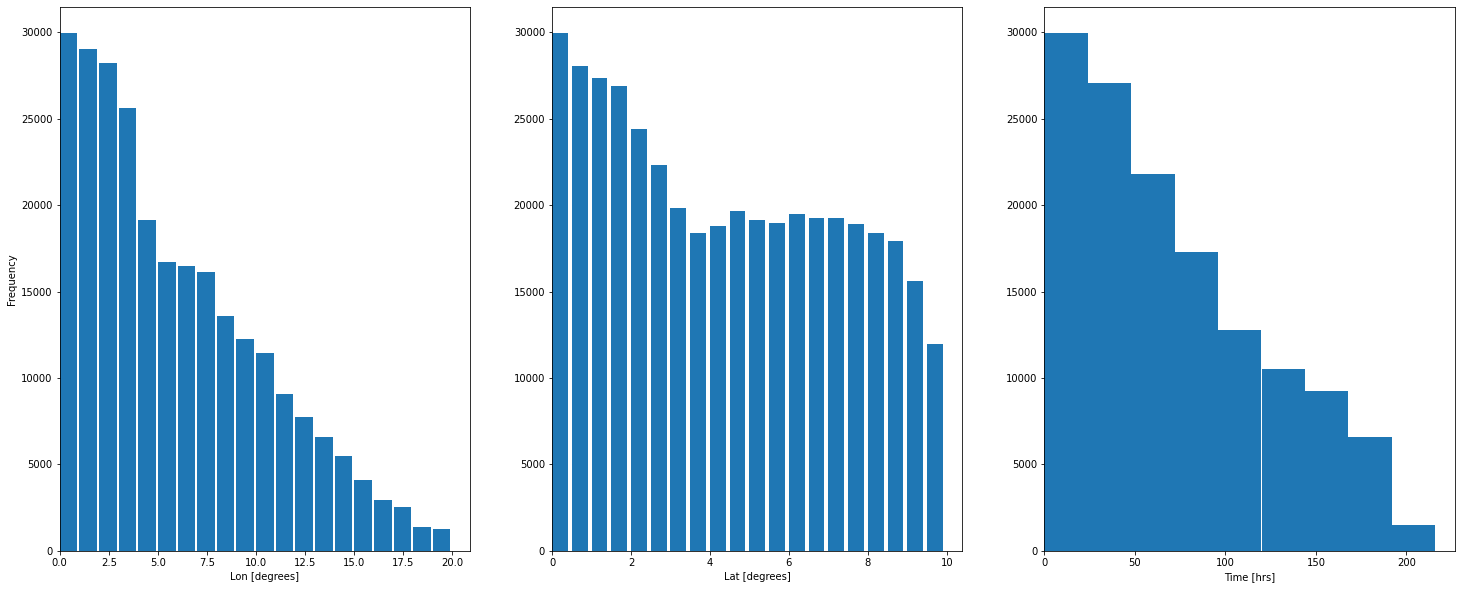

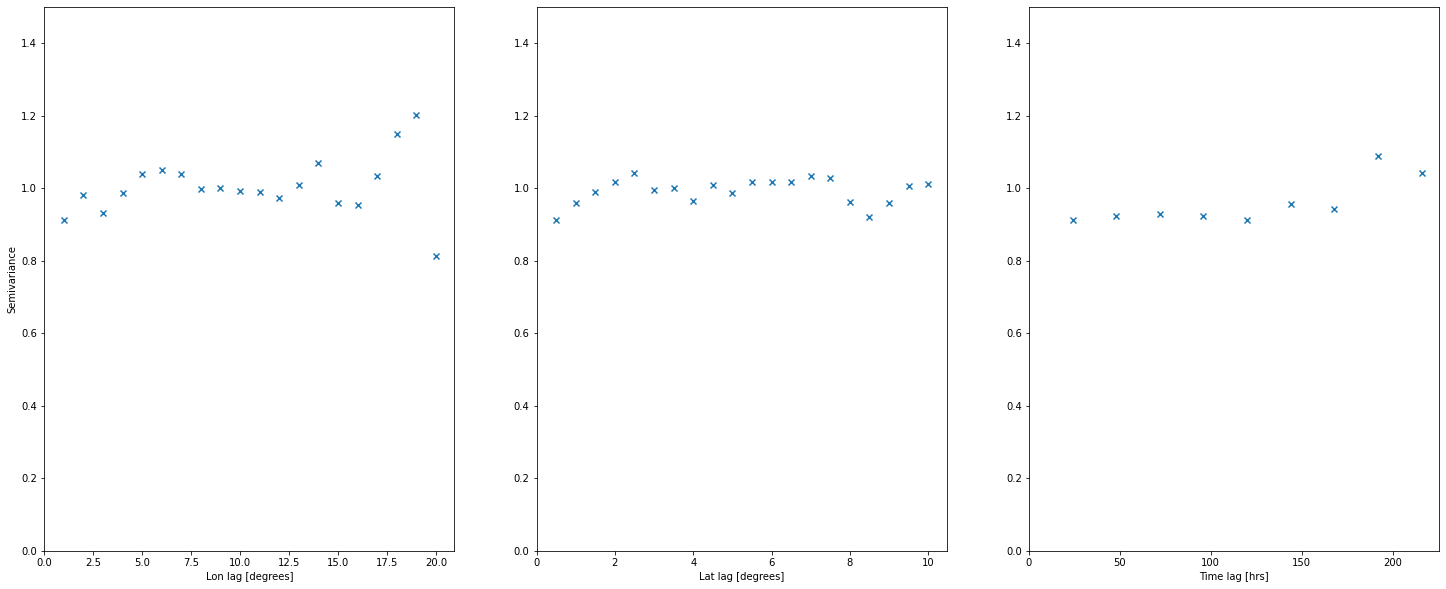

In [37]:
from ocean_navigation_simulator.generative_error_model.variogram.Variogram import Variogram
from ocean_navigation_simulator.generative_error_model.variogram.VisualizeVariogram import VisualizeVariogram

data = pd.read_csv("/home/jonas/Downloads/synthetic_error.csv")
v = Variogram(data)
v.detrend(detrend_var="lat", num_bins=1)
# (50, 100, 24)
v.build_variogram_gen((1, 0.5, 24), num_workers=2, chunk_size=int(1e6), detrended=True, units="degrees")

Vvis = VisualizeVariogram(v)
slicing_tol = [1, 1, 1]
view_range = [20,20,20]
Vvis.plot_histograms(tol=slicing_tol, view_range=view_range)
Vvis.plot_variograms(variable="u", tol=slicing_tol, view_range=view_range)